In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as sk

In [2]:
query_names = ['0','1','11','19','24','25','26']
#query_names = [str(x) for x in range(0,27)]
train_names = ['scenes/m1.png','scenes/m2.png','scenes/m3.png','scenes/m4.png','scenes/m5.png']
#train_names = ['scenes/h5.jpg']

sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

LOWE_COEFFICIENT = 0.8
MAX_COLOR_DISTANCE = 60
MIN_KP = 90

query_keypoints = []
query_descriptors = []

train_keypoints = []
train_descriptors = []

train_imgs = []
query_imgs = []

train_imgs_bgr = []
query_imgs_bgr = []

for query in query_names:
    query='models/'+query+'.jpg'
    q = cv2.imread(query, 0)
    query_imgs.append(q)
    query_imgs_bgr.append(cv2.imread(query))
    kp, des = sift.detectAndCompute(q, None)
    query_keypoints.append(kp)
    query_descriptors.append(des)

for train in train_names:
    t = cv2.imread(train, 0)
    train_imgs.append(t)
    train_imgs_bgr.append(cv2.imread(train))
    kp, des = sift.detectAndCompute(t, None)
    train_keypoints.append(kp)
    train_descriptors.append(des)

In [3]:
def find_good_matches(des_query, des_train, kp_query, kp_train):
    
    #here query represent train and train represent the query template 
    
    matches = bf.knnMatch(des_train, des_query, k=2)

    # We will collect the good keypoints in these lists

    good_matches = []

    for m,n in matches:
        if m.distance < LOWE_COEFFICIENT * n.distance:

            # trainIdx and queryIdx are attributes of the Match object

            good_matches.append(m)

    return good_matches

In [4]:
def find_baricenter(keypoints):
    sum_of_coordinates = np.array([0,0])

    for i in keypoints:
        sum_of_coordinates = sum_of_coordinates + i.pt

    baricenter = [sum_of_coordinates[0]/len(keypoints),sum_of_coordinates[1]/len(keypoints)]
    
    return baricenter


In [5]:
def HGT_transform(good_matches,baricenter):
    
    scale_ratios = []
    rotations = []
    x_center = []
    y_center = []

    for m in good_matches:

        query_center = baricenter
        train_kp = kp_train[m.queryIdx]
        query_kp = kp_query[m.trainIdx]

        query_vector = np.array(query_kp.pt)-np.array(query_center)

        scale_kp = train_kp.size / query_kp.size
        scale_ratios.append(scale_kp)

        rot_kp = train_kp.angle - query_kp.angle
        rotations.append(rot_kp)

        #train_vector_x = train_kp.pt[0] - scale_kp * (np.cos(rot_kp) * query_vector[0] - np.sin(rot_kp) * query_vector[1])
        train_vector_x = train_kp.pt[0] - scale_kp * query_vector[0]
        x_center.append(train_vector_x)

        #train_vector_y = train_kp.pt[1] - scale_kp * (np.sin(rot_kp) * query_vector[0] + np.cos(rot_kp) * query_vector[1])
        train_vector_y = train_kp.pt[1] - scale_kp * query_vector[1]
        y_center.append(train_vector_y) 
    
    return scale_ratios, rotations, x_center, y_center

In [6]:
def compute_bin_values(template,scale_ratios,train):
    
    counts_scale, bins_scale, _ = plt.hist(scale_ratios, bins='auto')
    scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
    x_bin_size = scale * template.shape[1] / 4
    y_bin_size = scale * template.shape[0] / 4
    x_bins = int(np.ceil(train.shape[1] / x_bin_size)+2)
    y_bins = int(np.ceil(train.shape[0] / y_bin_size)+2)
    
    return x_bin_size, y_bin_size, x_bins, y_bins

In [7]:
def compute_votation(x_bins, y_bins,good_matches):
    accumulator_matches = {}
    accumulator_mask = np.zeros((x_bins, y_bins))
    for i,m in enumerate(good_matches):
        x = int(np.floor(x_center[i]/(x_bin_size)))
        y = int(np.floor(y_center[i]/(y_bin_size)))
        s = scale_ratios[i]
        r = rotations[i]
        accumulator_matches[(x,y)] = accumulator_matches.get((x,y), [])
        accumulator_matches[(x,y)].append(m)
        if x>0 and y>0 and x< x_bins and y<y_bins:
            accumulator_mask[x,y] += 1

    mask = sk.local_maxima(accumulator_mask)
    accumulator_mask[mask != 1]=0
    accumulator_mask[accumulator_mask<6]=0
    
    return accumulator_mask,accumulator_matches

In [8]:
def compute_destination_boxes(accumulator_matches,accumulator_mask,kp_template,kp_train,query_img_bgr):
    
    dst = []
    dst_kp = []
    
    
    for i in accumulator_matches.keys():
        if i[0]>=0 and i[1]>=0 and i[1]<accumulator_mask.shape[1] and i[0]<accumulator_mask.shape[0]:
            if (accumulator_mask[i[0],i[1]]>0):

                src_pts = []
                dst_pts = []
                
                for m in accumulator_matches[i]:
                    src_pts.append(kp_template[m.trainIdx].pt)
                    dst_pts.append(kp_train[m.queryIdx].pt)
                
                if (len(src_pts)>MIN_KP):
                
                    M, _ = cv2.findHomography(np.float32(src_pts).reshape(-1,1,2),np.float32(dst_pts).reshape(-1,1,2),cv2.RANSAC,5.0)

                    h, w, d = query_img_bgr.shape
                    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1,1,2)

                    dst.append(cv2.perspectiveTransform(pts, M).reshape(-1,2))
                    dst_kp.append(len(src_pts))

    return dst,dst_kp

In [9]:
def color_consistency(query_img_bgr, train_img_crop):
    
    query_avg_color = query_img_bgr.reshape(-1,3).mean(axis=0)
    train_avg_color = train_img_crop.reshape(-1,3).mean(axis=0)

    color_distance = np.sqrt(sum(v ** 2 for v in (query_avg_color-train_avg_color)))
    
    '''print('query')
    plt.imshow(query_img_bgr)
    plt.show()
    print('crop')
    plt.imshow(train_img_crop)
    plt.show()
    print('difference',color_distance)'''
    
    return color_distance < MAX_COLOR_DISTANCE

In [10]:
def filter_destination_boxes(query_img_bgr,dst_boxes_,train_img_bgr,dst_kp):
    
    found_query_boxes = []
    found_query_kp = []
    
    for i,dst_box in enumerate(dst_boxes):
        
        height, width, _ = train_img_bgr.shape
            
        center = (sum((dst_box[:,0])/4),sum((dst_box[:,1])/4))

        x_min = int(min(dst_box[:,0])) # dst_box[:,0] is all x coordinates
        x_max = int(max(dst_box[:,0]))
        y_min = int(min(dst_box[:,1])) # dst_box[:,1] is all y coordinates
        y_max = int(max(dst_box[:,1]))

        train_img_crop = train_img_bgr[max(y_min,0):min(y_max,height),
                                       max(x_min,0):min(x_max,width)]
        
        if color_consistency(query_img_bgr, train_img_crop):      

            found_query_boxes.append(dst_box)
            found_query_kp.append(dst_kp[i])
            
    return found_query_boxes, found_query_kp

In [11]:
def filter_multiple(dst_boxes, kps):
    
    filtered_boxes = []
    filtered_kps = []
    query_boxes = {}
    instances_found = [0]*len(query_names)
    
    for name, boxes in enumerate(dst_boxes):
        for i,box in enumerate(boxes):
            if len(box)!=0:
                box = np.array(box).reshape(-1,2)
                x_min = int(min(box[:,0])) # dst_box[:,0] is all x coordinates
                x_max = int(max(box[:,0]))
                y_min = int(min(box[:,1])) # dst_box[:,1] is all y coordinates
                y_max = int(max(box[:,1]))
                center = (sum((box[:,0])/4),sum((box[:,1])/4))
                f = filtered_boxes.copy()
                put = True
                for j,found_box in enumerate(f):
                    found_box = np.array(found_box).reshape(-1,2)
                    x_found_min = int(min(found_box[:,0])) # dst_box[:,0] is all x coordinates
                    x_found_max = int(max(found_box[:,0]))
                    y_found_min = int(min(found_box[:,1])) # dst_box[:,1] is all y coordinates
                    y_found_max = int(max(found_box[:,1]))
                    found_center = (sum((found_box[:,0])/4),sum((found_box[:,1])/4))
                    if (found_center[0] > x_min and found_center[0] < x_max\
                                and found_center[1] > y_min and found_center[1] < y_max)\
                                or\
                                (center[0] > x_found_min and center[0] < x_found_max\
                                and center[1] > y_found_min and center[1] < y_found_max):
                                    # è lo stesso ed è meglio
                                    if(kps[i] > filtered_kps[j]):
                                        filtered_boxes.remove(found_box)
                                        filtered_kps.remove(filtered_kps[j])
                                        instances_found[i] -= 1  
                                    # è lo stesso ed è peggio
                                    else:
                                        put = False
                if put:
                    filtered_boxes.append(box)
                    filtered_kps.append(kps[i])
                    query_name = query_names[name]
                    instances_found[name] += 1
    
    for i,instances in enumerate(instances_found):
        if instances !=0:
            print('Found query ',query_names[i],':',instances,'times')
            
    for v in filtered_boxes:
        box = np.array(v).reshape(-1,2)
        x_min = int(min(box[:,0])) # dst_box[:,0] is all x coordinates
        x_max = int(max(box[:,0]))
        y_min = int(min(box[:,1])) # dst_box[:,1] is all y coordinates
        y_max = int(max(box[:,1]))
        width = x_max - x_min
        height = y_max - y_min
        center = (sum((box[:,0])/4),sum((box[:,1])/4))        
        print('Found box at position:',str(center),', width:',str(width),'px, height:',str(height),'px \n')
        
    return filtered_boxes,query_boxes,instances_found

In [12]:
def draw_boxes(found_query_boxes, query_crop_pts, train_img_bgr, query_names):
    
    train_img_rgb = cv2.cvtColor(train_img_bgr, cv2.COLOR_BGR2RGB)
    
    for k,v in found_query_boxes.items():
    
        train_img_rgb = cv2.polylines(train_img_rgb, [np.int32(v)], True, (0,255,0), 3, cv2.LINE_AA)
        center = [int(i) for i in query_crop_pts[k]['center']]
        cv2.putText(train_img_rgb, query_names[k], tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 10, cv2.LINE_AA)
        
    plt.imshow(train_img_rgb)
    plt.show()

Found query  24 : 2 times
Found query  25 : 1 times
Found query  26 : 1 times
Found box at position: (184.46375846862793, 213.74926471710205) , width: 365 px, height: 506 px 

Found box at position: (550.2792739868164, 219.48659467697144) , width: 340 px, height: 494 px 

Found box at position: (1261.6322021484375, 233.81808745861053) , width: 323 px, height: 449 px 

Found box at position: (921.3873443603516, 218.44671964645386) , width: 337 px, height: 489 px 



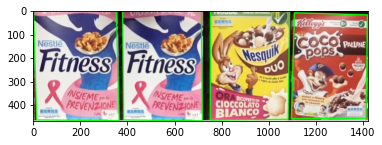

Found query  0 : 1 times
Found query  1 : 2 times
Found query  11 : 1 times
Found box at position: (178.98006737232208, 300.3298110961914) , width: 347 px, height: 460 px 

Found box at position: (848.4529418945312, 258.452112197876) , width: 317 px, height: 416 px 

Found box at position: (1180.6867980957031, 255.35443496704102) , width: 308 px, height: 415 px 

Found box at position: (511.1637649536133, 252.23253631591797) , width: 312 px, height: 402 px 



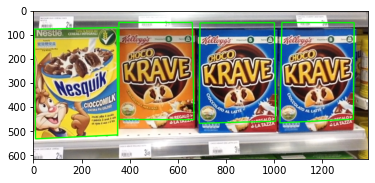

Found query  19 : 1 times
Found query  25 : 2 times
Found query  26 : 1 times
Found box at position: (1232.8936767578125, 189.74993002414703) , width: 301 px, height: 385 px 

Found box at position: (557.8019104003906, 221.48086541891098) , width: 343 px, height: 464 px 

Found box at position: (890.4559020996094, 227.77279460430145) , width: 328 px, height: 450 px 

Found box at position: (195.38043189048767, 206.51777172088623) , width: 364 px, height: 508 px 



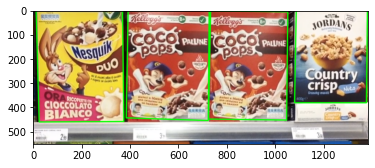

Found query  24 : 2 times
Found query  25 : 2 times
Found query  26 : 1 times
Found box at position: (160.99235200881958, 191.40570259094238) , width: 380 px, height: 511 px 

Found box at position: (540.0376205444336, 195.72893810272217) , width: 360 px, height: 505 px 

Found box at position: (1273.9330749511719, 266.8496856689453) , width: 413 px, height: 573 px 

Found box at position: (1589.0197448730469, 282.38033989071846) , width: 411 px, height: 582 px 

Found box at position: (921.6129608154297, 195.76360988616943) , width: 344 px, height: 497 px 



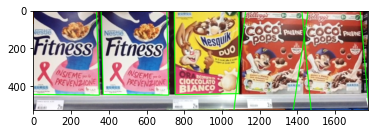

Found query  1 : 2 times
Found query  11 : 1 times
Found query  19 : 1 times
Found query  25 : 2 times
Found box at position: (500.5034866333008, 721.2736968994141) , width: 317 px, height: 415 px 

Found box at position: (833.2408294677734, 717.0483093261719) , width: 308 px, height: 415 px 

Found box at position: (163.38627290725708, 714.5450744628906) , width: 312 px, height: 403 px 

Found box at position: (908.5489044189453, 190.05678862333298) , width: 301 px, height: 386 px 

Found box at position: (231.92031717300415, 266.96462965011597) , width: 403 px, height: 549 px 

Found box at position: (570.1462554931641, 286.81932163238525) , width: 410 px, height: 580 px 



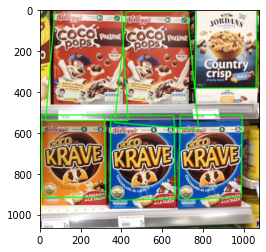

In [13]:
for i,train_img_bgr in enumerate(train_imgs_bgr):
    
    kp_train, des_train = train_keypoints[i], train_descriptors[i]
    
    found_query_boxes = []
    found_query_kps = []
    query_crop_pts = {}
    query_good_matches = {}
    dst_boxes = []
    
    train_img = cv2.cvtColor(train_img_bgr, cv2.COLOR_BGR2RGB)

    for j,query_img_bgr in enumerate(query_imgs_bgr):
        
        kp_query, des_query = query_keypoints[j], query_descriptors[j]
        
        good_matches = find_good_matches( des_query, des_train, kp_query, kp_train)
        
        scale_ratios, rotations, x_center, y_center = HGT_transform(good_matches,find_baricenter(kp_query))
        
        x_bin_size, y_bin_size, x_bins, y_bins = compute_bin_values(query_img_bgr,scale_ratios,train_img_bgr)
        
        accumulator_mask,accumulator_matches = compute_votation(x_bins, y_bins,good_matches)
        
        dst_boxes, dst_kp = compute_destination_boxes(accumulator_matches,accumulator_mask,kp_query,kp_train,query_img_bgr)
        
        filtered_boxes, filtered_kp = filter_destination_boxes(query_img_bgr,dst_boxes,train_img_bgr,dst_kp)
        
        found_query_boxes.append(filtered_boxes)
        found_query_kps.append(filtered_kp)
        
    found_query_boxes,query_boxes,instances_found = filter_multiple(found_query_boxes, found_query_kps)
    

    #for dst_boxes in found_query_boxes:
    #    for d in dst_boxes:
    #        train_img = cv2.polylines(train_img, [np.int32(d)], True, (0,255,0), 3, cv2.LINE_AA)
        
    for dst_box in found_query_boxes:
            train_img = cv2.polylines(train_img, [np.int32(dst_box)], True, (0,255,0), 3, cv2.LINE_AA)

    plt.imshow(train_img)
    plt.show()